Task 1: Clustering

The final goal is clustering how users charge their cars based on:

* time of day
* day of the week

maybe
* charging station preference (location)
* overstaying past full-charge

In [228]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta
from permetrics import ClusteringMetric
from sklearn.cluster import DBSCAN
from scipy.stats import zscore

# Example usage
pd.set_option('display.width', 200)  # Adjust the width based on your screen size
pd.set_option('display.max_columns', None)  # Show all columns without truncation


In [229]:
# Load the CSV file
def load_csv(path_dataset):
    # Load data into a DataFrame
    data = pd.read_csv(path_dataset)
    return data


# Load data
path_dataset = "../data/EVChargingStationUsage.csv"
original_data = load_csv(path_dataset)
print(f"Dataset shape: {original_data.shape}\n\n")
original_data.head()


Dataset shape: (259415, 33)




/tmp/ipykernel_3059/3536394953.py:4: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path_dataset)


,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Port Number,Plug Type,EVSE ID,Address 1,City,State/Province,Postal Code,Country,Latitude,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,6.249457,2.625,0.784,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,0.106588,0.045,0.013,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,14.951777,6.280,1.876,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,7.159643,3.007,0.899,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,1.957765,0.822,0.246,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


Before we start cleaning the data, let's extract the features we're interested in

In [230]:
# features_df = original_data.head(30000).copy()  # Make a copy to avoid modification of the original data
features_df = original_data.copy()


# Use .loc to ensure you are modifying the DataFrame in a safe manner
features_df.loc[:, "Start Date"] = pd.to_datetime(features_df["Start Date"])
features_df.loc[:, "Charging Time (hh:mm:ss)"] = pd.to_timedelta(features_df["Charging Time (hh:mm:ss)"])

# Set the 'Start Date' column as the index
features_df = features_df.set_index("Start Date")
features_df = features_df[features_df.index.year == 2020]

# Select specific columns
features_df = features_df[["User ID", "Station Name", "Energy (kWh)", "Charging Time (hh:mm:ss)"]]

print(features_df.shape)
features_df.head()

(20097, 4)


/home/radugrecu97/dtu/semesters/1/business_analytics/Energy-and-Mobility/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,User ID,Station Name,Energy (kWh),Charging Time (hh:mm:ss)
Start Date,,,,
2020-01-01 09:11:00,2653661,PALO ALTO CA / WEBSTER #1,12.885,0 days 02:08:25
2020-01-01 09:32:00,278359,PALO ALTO CA / WEBSTER #2,5.936,0 days 01:47:06
2020-01-01 09:44:00,2024201,PALO ALTO CA / HAMILTON #2,3.652,0 days 01:12:40
2020-01-01 09:45:00,292835,PALO ALTO CA / MPL #6,6.031,0 days 01:00:15
2020-01-01 09:45:00,20229301,PALO ALTO CA / MPL #4,32.260,0 days 05:22:07


Let's check for type consistency

In [231]:
def check_dtypes(df):
    # Iterate over all columns in the DataFrame
    for column in df.columns:
        # Get the unique types in the column
        unique_types = df[column].apply(type).unique()
        
        # If the length of unique_types is greater than 1, the column has mixed data types
        if len(unique_types) > 1:
            print(f"The column '{column}' has mixed data types: {unique_types}")
        else:
            print(f"The column '{column}' has a consistent data type: {unique_types[0]}")

check_dtypes(features_df)

The column 'User ID' has mixed data types: [<class 'str'> <class 'float'>]
The column 'Station Name' has a consistent data type: <class 'str'>
The column 'Energy (kWh)' has a consistent data type: <class 'float'>
The column 'Charging Time (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


So it seems 'User ID' has mixed datatypes - floats and strings. The string values are either in non-decimal representation e.g. '154551' or they also contain a 'V' character at the end e.g. '263V'.

We'll convert all the floats to non-decimal representation and then to string.

There are also some entries with empty 'User ID':

In [232]:
def check_nan(df):
    for column in df.columns:
        print(column)
        # Filter the rows where column is NaN
        print(df[df[column].isna()])
        print("\n\n")

check_nan(features_df)


User ID
                    User ID                 Station Name  Energy (kWh) Charging Time (hh:mm:ss)
Start Date                                                                                     
2020-01-01 13:28:00     NaN     PALO ALTO CA / BRYANT #6         9.961          0 days 01:37:45
2020-01-02 07:41:00     NaN  PALO ALTO CA / CAMBRIDGE #5         5.768          0 days 01:50:03
2020-01-02 08:22:00     NaN       PALO ALTO CA / HIGH #1         4.098          0 days 00:39:54
2020-01-02 10:13:00     NaN   PALO ALTO CA / HAMILTON #2         0.629          0 days 00:07:01
2020-01-02 10:46:00     NaN  PALO ALTO CA / CAMBRIDGE #3         5.904          0 days 01:47:08
...                     ...                          ...           ...                      ...
2020-12-30 14:32:00     NaN        PALO ALTO CA / MPL #6         1.389          0 days 00:13:52
2020-12-30 17:57:00     NaN    PALO ALTO CA / WEBSTER #2         7.441          0 days 02:38:40
2020-12-31 11:15:00     NaN     

Only 'User ID' column has Nan values.

7677 rows consists 2.9% of the total. Since we're interested in targeting individual users in the final model, we choose to drop it.

In another case, if we were interested in clustering overall charging station usage, it would make sense to keep these rows as the 'User ID' isn't relevant.

In [233]:
# Convert 'User ID' to integer for numeric values and leave non-numeric as is
def convert_to_int_if_numeric(value):
    try:
        # If the value is numeric, convert to int
        return int(float(value))
    except ValueError:
        # If it's not numeric (raises ValueError), leave it as it is
        return value
    
# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)  # Try to convert the value to float
        return True    # If successful, it is numeric
    except ValueError:
        return False   # If an error occurs, it's not numeric


# # Remove rows with missing, invalid 'User D' and convert to int
features_clean_df = features_df.copy().dropna(subset=["User ID"])
features_clean_df["User ID"] = features_clean_df["User ID"].apply(convert_to_int_if_numeric)
features_clean_df = features_clean_df[features_clean_df["User ID"] != 0]

# Convert 'User ID' column to string type
features_clean_df["User ID"] = features_clean_df["User ID"].astype(str)
print(f"Converted Column\n\n{features_clean_df["User ID"]}\n\n")

# Filter the rows where 'User ID' is not numeric (non-numeric strings)
non_numeric = features_clean_df[~features_clean_df["User ID"].apply(is_numeric)]

# Print the non-numeric User IDs
print(f"Non-Numeric IDs\n{non_numeric[["User ID"]]}")

Converted Column

Start Date
2020-01-01 09:11:00     2653661
2020-01-01 09:32:00      278359
2020-01-01 09:44:00     2024201
2020-01-01 09:45:00      292835
2020-01-01 09:45:00    20229301
                         ...   
2020-12-31 16:39:00     2024201
2020-12-31 16:48:00      242661
2020-12-31 17:28:00      449995
2020-12-31 17:49:00      804075
2020-12-31 18:19:00     2022651
Name: User ID, Length: 19364, dtype: object


Non-Numeric IDs
                     User ID
Start Date                  
2020-02-14 07:55:00  100061V
2020-02-27 08:19:00  100061V
2020-03-03 20:28:00   87471V
2020-08-25 10:50:00  100161V
2020-09-17 08:39:00  100161V
2020-09-29 11:15:00  100161V


In [234]:
check_dtypes(features_clean_df)

The column 'User ID' has a consistent data type: <class 'str'>
The column 'Station Name' has a consistent data type: <class 'str'>
The column 'Energy (kWh)' has a consistent data type: <class 'float'>
The column 'Charging Time (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


Now all the columns are consistent in data type.

Let's check for outliers in "Energy (kWh)".

NOTE:

We are concerned with simply removing the outliers first and plotting STANDARDISED 'Energy (kWh)' is only for visual purposes. We will delay standardised until a later step where we calculate an average.

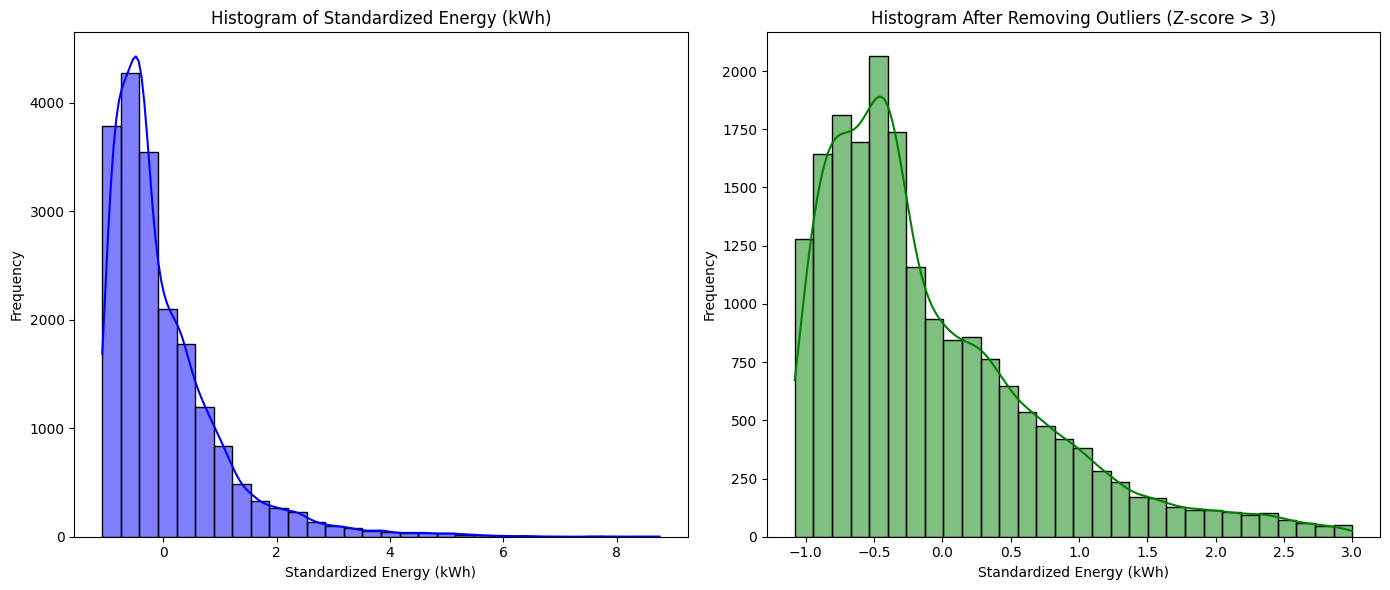

In [235]:
# Standardize the 'Energy (kWh)' column
scaler = StandardScaler()

standardised_df = features_clean_df.copy()
standardised_df['Energy (kWh) Standardised'] = scaler.fit_transform(standardised_df[['Energy (kWh)']])

# Calculate Z-scores
standardised_df['Z-Score'] = zscore(standardised_df['Energy (kWh) Standardised'])

# Remove outliers (Z-score > 3 or < -3)
standardised_no_outliers_df = standardised_df[standardised_df['Z-Score'].abs() <= 3]

# Drop Z-Score column (we no longer need it for plotting)
no_outliers_df = standardised_no_outliers_df.drop(columns=['Energy (kWh) Standardised', 'Z-Score'])

# Set up the plot with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First Histogram: Standardized 'Energy (kWh)' (before removing outliers)
sns.histplot(standardised_df['Energy (kWh) Standardised'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Histogram of Standardized Energy (kWh)')
axes[0].set_xlabel('Standardized Energy (kWh)')
axes[0].set_ylabel('Frequency')

# Second Histogram: Standardized 'Energy (kWh)' after removing outliers
sns.histplot(standardised_no_outliers_df['Energy (kWh) Standardised'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Histogram After Removing Outliers (Z-score > 3)')
axes[1].set_xlabel('Standardized Energy (kWh)')
axes[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


Cleaned data frame:

In [236]:
print(no_outliers_df.shape)
no_outliers_df.head()

(18982, 4)


,User ID,Station Name,Energy (kWh),Charging Time (hh:mm:ss)
Start Date,,,,
2020-01-01 09:11:00,2653661,PALO ALTO CA / WEBSTER #1,12.885,0 days 02:08:25
2020-01-01 09:32:00,278359,PALO ALTO CA / WEBSTER #2,5.936,0 days 01:47:06
2020-01-01 09:44:00,2024201,PALO ALTO CA / HAMILTON #2,3.652,0 days 01:12:40
2020-01-01 09:45:00,292835,PALO ALTO CA / MPL #6,6.031,0 days 01:00:15
2020-01-01 09:45:00,20229301,PALO ALTO CA / MPL #4,32.260,0 days 05:22:07


Data Preparation:

Split the charging events into 1 hour buckets.

In [237]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Function to split the charging event into hours
def split_charging_events(row):
    start = row.name  # Access the index (Start Date)
    duration = row['Charging Time (hh:mm:ss)']
    total_energy = row['Energy (kWh)']
    
    hours = int(np.ceil(duration.total_seconds() / 3600))  # Total number of hour blocks
    results = []
    
    for i in range(hours):
        block_start = start.replace(minute=0, second=0, microsecond=0) + timedelta(hours=i)  # Set time to the top of the hour
        
        # Determine the duration for this block
        if i == 0:
            block_duration = min(timedelta(hours=1), duration)
        elif i == hours - 1:
            block_duration = duration - timedelta(hours=(hours - 1))
        else:
            block_duration = timedelta(hours=1)
        
        # Proportional energy calculation
        block_energy = total_energy * (block_duration.total_seconds() / duration.total_seconds())
        
        # Append a new row with split details
        results.append({
            'Start Date': block_start,
            'User ID': row['User ID'],
            'Energy (kWh)': block_energy
        })
    
    # Return a DataFrame for the split details of the current row
    return pd.DataFrame(results)

# Apply the function to each row and concatenate results
hourly_consumption_df = pd.concat([split_charging_events(row) for _, row in no_outliers_df.iterrows()], ignore_index=True)

# Print final output
hourly_consumption_df


,Start Date,User ID,Energy (kWh)
0,2020-01-01 09:00:00,2653661,6.020247
1,2020-01-01 10:00:00,2653661,6.020247
2,2020-01-01 11:00:00,2653661,0.844507
3,2020-01-01 09:00:00,278359,3.325490
4,2020-01-01 10:00:00,278359,2.610510
...,...,...,...
45780,2020-12-31 17:00:00,804075,3.074711
45781,2020-12-31 18:00:00,804075,3.074711
45782,2020-12-31 19:00:00,804075,3.074711
45783,2020-12-31 20:00:00,804075,2.751866


Since we're more interested in daily and weekly patterns, we'll split the 'Start Date' into 'Hour' of the day and 'Day of the week'.
We start with 'Hour' of the day and average the energy usage by every user at every 'Hour'

In [238]:
# Assuming 'Start Date' is already a datetime column
hourly_energy_per_day_df = hourly_consumption_df.copy()
hourly_energy_per_day_df = hourly_energy_per_day_df.reset_index()
hourly_energy_per_day_df = hourly_energy_per_day_df.set_index("User ID")

# Extract day of the week and hour into new columns
hourly_energy_per_day_df['Hour'] = hourly_energy_per_day_df['Start Date'].dt.hour  # Hour in 24-hour format
hourly_energy_per_day_df['Day of Week'] = hourly_energy_per_day_df['Start Date'].dt.day_name()  # Extract day of the week

# Drop 'Start Date' as it's no longer needed
hourly_energy_per_day_df = hourly_energy_per_day_df.drop(columns="Start Date")

# Group by 'User ID' and 'Hour' and calculate the mean of 'Energy (kWh)'
hourly_energy_per_day_df = hourly_energy_per_day_df.groupby(['User ID', 'Hour', 'Day of Week'])['Energy (kWh)'].mean().reset_index()

# Set 'User ID' as the index again
hourly_energy_per_day_df = hourly_energy_per_day_df.set_index("User ID")

# Show the DataFrame
hourly_energy_per_day_df


,Hour,Day of Week,Energy (kWh)
User ID,,,
100061V,7,Friday,5.253000
100061V,8,Thursday,5.747140
100061V,9,Thursday,5.747140
100061V,10,Thursday,3.521720
100161V,8,Thursday,5.314642
...,...,...,...
997831,17,Monday,0.299689
997831,17,Saturday,1.538496
99943,16,Thursday,2.813428


/tmp/ipykernel_3059/2770256787.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=workday_hour_counts.index, y=workday_hour_counts.values, palette='viridis')


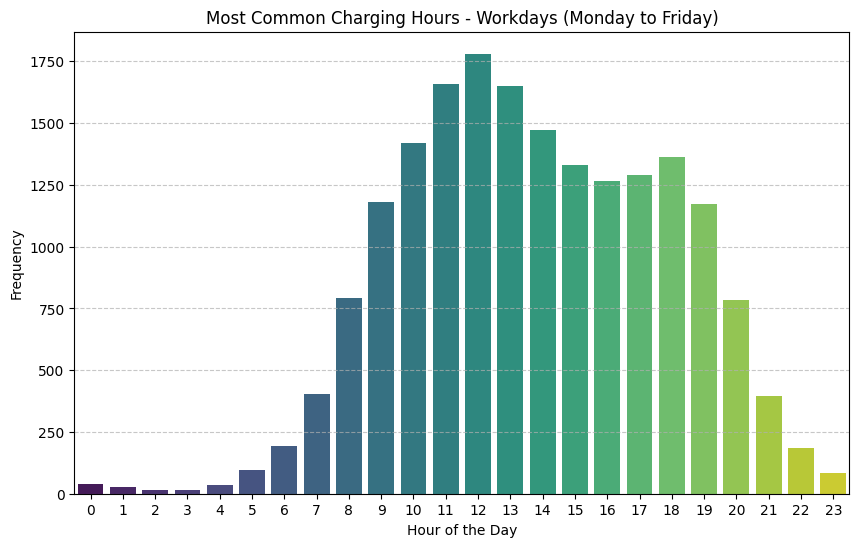

/tmp/ipykernel_3059/2770256787.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekend_hour_counts.index, y=weekend_hour_counts.values, palette='viridis')


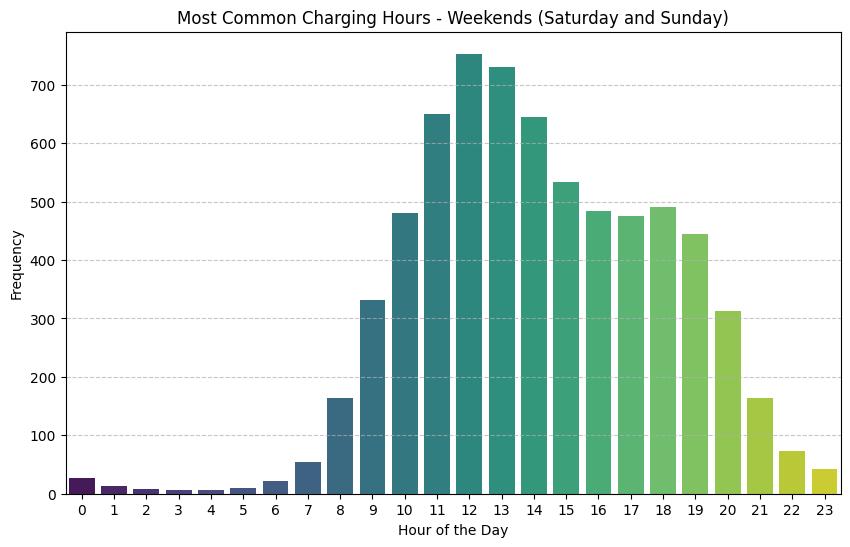

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for workdays (Monday to Friday) and weekends (Saturday & Sunday)
workdays = hourly_energy_per_day_df[hourly_energy_per_day_df['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekends = hourly_energy_per_day_df[hourly_energy_per_day_df['Day of Week'].isin(['Saturday', 'Sunday'])]

# Count occurrences of 'Hour' for workdays and weekends
workday_hour_counts = workdays['Hour'].value_counts().sort_values(ascending=False)
weekend_hour_counts = weekends['Hour'].value_counts().sort_values(ascending=False)

# Plot for workdays
plt.figure(figsize=(10, 6))
sns.barplot(x=workday_hour_counts.index, y=workday_hour_counts.values, palette='viridis')
plt.title('Most Common Charging Hours - Workdays (Monday to Friday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(24))  # Ensure all hours are shown on the X-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for weekends
plt.figure(figsize=(10, 6))
sns.barplot(x=weekend_hour_counts.index, y=weekend_hour_counts.values, palette='viridis')
plt.title('Most Common Charging Hours - Weekends (Saturday and Sunday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(24))  # Ensure all hours are shown on the X-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [245]:
dated_df = hourly_energy_per_day_df.copy()
# Create a binary feature that is 1 for Saturday and Sunday, and 0 otherwise
dated_df['Weekend'] = dated_df['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)
# Group by 'User ID' and 'Weekend', then sum energy consumption
energy_by_weekend_df = dated_df.groupby(['User ID', 'Weekend'])['Energy (kWh)'].sum().unstack(fill_value=0)

# Rename the columns for clarity
energy_by_weekend_df.columns = ['Weekday Energy (kWh)', 'Weekend Energy (kWh)']
energy_by_weekend_df


,Weekday Energy (kWh),Weekend Energy (kWh)
User ID,,
100061V,20.269000,0.000000
100161V,23.592600,0.000000
1001801,9.348000,0.000000
1002211,0.000000,8.295000
100243,10.831118,0.777000
...,...,...
992951,15.350000,0.000000
993001,0.000000,4.127000
99583,8.277000,0.000000


Standardize the average 'Energy (kWh)'

In [246]:
# Copy the original DataFrame to avoid modifying it directly
energy_by_weekend_std_df = energy_by_weekend_df.copy()

# Standardize only the 'Energy (kWh)' column
scaler = StandardScaler()
energy_by_weekend_std_df['Weekday Energy (kWh)'] = scaler.fit_transform(energy_by_weekend_std_df[['Weekday Energy (kWh)']])
energy_by_weekend_std_df['Weekend Energy (kWh)'] = scaler.fit_transform(energy_by_weekend_std_df[['Weekend Energy (kWh)']])
# Display the resulting DataFrame
energy_by_weekend_std_df


,Weekday Energy (kWh),Weekend Energy (kWh)
User ID,,
100061V,0.069287,-0.483042
100161V,0.162019,-0.483042
1001801,-0.235421,-0.483042
1002211,-0.496241,0.128809
100243,-0.194041,-0.425730
...,...,...
992951,-0.067959,-0.483042
993001,-0.496241,-0.178629
99583,-0.265303,-0.483042


In [247]:
def print_elbow_plot(scaled_df, title_suffix):
    wcss = []  # List to store within-cluster sum of squares

    # Calculate WCSS for cluster numbers ranging from 1 to 10
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(scaled_df)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to the closest cluster center

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title(f'Optimal Number of Clusters for {title_suffix}')
    plt.xticks(np.arange(1, 11, 1))  # Ensure all cluster numbers are shown
    plt.grid(True)
    plt.show()

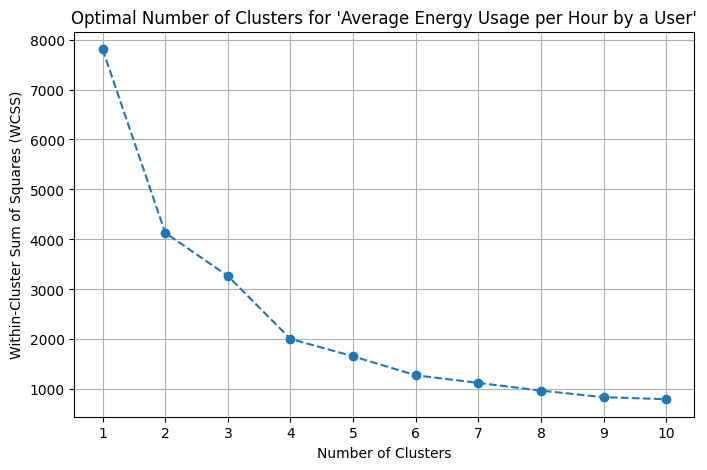

In [248]:
print_elbow_plot(energy_by_weekend_std_df, "'Average Energy Usage per Hour by a User'")

In [249]:
def print_kmeans(df, scaled_df, n_clusters, x_name, y_name, x_label, y_label, title):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model and predict clusters
    df['Cluster'] = kmeans.fit_predict(scaled_df)

    # Ensure scaled_df is a NumPy array for ClusteringMetric
    scaled_array = scaled_df.to_numpy()
    
    # Initialize ClusteringMetric for evaluation
    cm = ClusteringMetric(X=scaled_array, y_pred=df['Cluster'].values)
    
    # Compute DBCV score
    dbcv_score = cm.density_based_clustering_validation_index()
    
    # Scatter plot with KMeans clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df[x_name],
        y=df[y_name],
        hue=df['Cluster'],
        palette='viridis',  # Clearer color palette
        s=50
    )

    # Set X-axis ticks for 'Hour' labels
    if x_name == 'Hour':
        plt.xticks(range(0, 24))
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add DBCV score as text on the plot
    plt.text(0.95, 0.95, f'DBCV Score: {dbcv_score:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black')

    plt.legend(title='Cluster')
    plt.show()


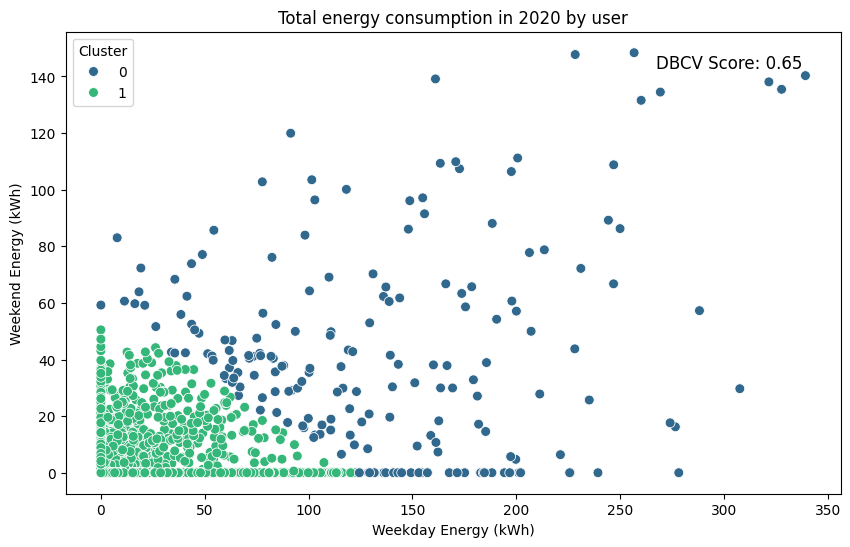

In [ ]:
print_kmeans(df=energy_by_weekend_df,
             scaled_df=energy_by_weekend_std_df,
             n_clusters=2,
             x_name="Weekday Energy (kWh)",
             y_name="Weekend Energy (kWh)",
             x_label="Weekday Energy (kWh)",
             y_label="Weekend Energy (kWh)",
             title="Total energy consumption in 2020 by weekend by user")

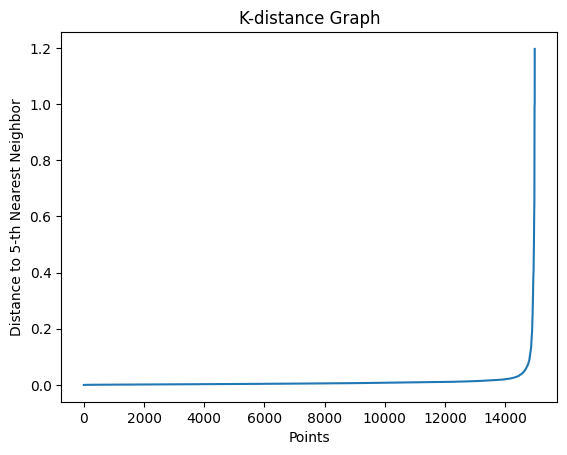

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your dataset
min_samples = 5  # Typically start with 4 or 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(mean_energy_std_df)
distances, indices = nbrs.kneighbors(mean_energy_std_df)

# Sort distances for each point and plot
distances = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel(f'Distance to {min_samples}-th Nearest Neighbor')
plt.show()


In [ ]:

def print_dbscan(scaled_df, eps, min_samples, x, y, xlabel, ylabel, title):
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Fit the DBSCAN model and predict clusters
    df['Cluster'] = dbscan.fit_predict(scaled_df)
    
    # Initialize ClusteringMetric for evaluation
    cm = ClusteringMetric(X=scaled_df, y_pred=df['Cluster'].values)
    
    # Compute DBCV score
    dbcv_score = cm.density_based_clustering_validation_index()  # You can also use cm.DBCVI()
    
    # Scatter plot with DBSCAN clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df[x],
        y=df[y],
        hue=df['Cluster'],
        palette=sns.color_palette(),
        s=15  # Optional: size of points
    )

    # Set X-axis ticks to show all hours (0 to 23) - optional based on data
    plt.xticks(range(0, 24))  # Ensure all hours are shown on the X-axis

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add DBCV score as text on the plot
    plt.text(0.95, 0.95, f'DBCV Score: {dbcv_score:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black')

    plt.legend(title='Cluster')
    plt.show()


In [ ]:
print_dbscan(df=mean_energy_per_hour,
             eps=,
             min_samples=,
             x="Hour",
             y="Energy (kWh)",
             xlabel="Hour of the day",
             ylabel="Average energy consumption(kWh)",
             title="Average Energy Consumption per hour by user")

SyntaxError: expected argument value expression (3228055131.py, line 2)

Cluster the users that always charge at peak hours, when most stations are in use at each location

Data preprocessing:

Station name will be one-hot encoded.
Charging time will be converted to seconds.